In [10]:
import random
import projetannuel

from lib_gridfs import load_posters_with_size, stock_metrics
imgs, genres = load_posters_with_size((15, 10), genres=['Horreur', 'Animation', 'Histoire'])
imgs_as_lists = [img.tolist() for img in imgs]
import numpy as np

imgs_as_lists = np.array(imgs_as_lists)/255.0

data = list(zip(imgs_as_lists, genres))
# filtered_data = [(img, genre) for img, genre in data if genre in ['Animation', 'Horreur']]
random.shuffle(data)
imgs_shuffled = [movie[0] for movie in data]
genres_shuffled = [movie[1] for movie in data]
# genres_shuffled_binarygenres_shuffled_binary = []
# for g in genres_shuffled:
#     .append(0 if g == "Horreur" else 1)
lim = int(len(data) * 0.8)
imgs_as_lists_train = imgs_shuffled[:lim]
genres_train = genres_shuffled[:lim]
imgs_as_lists_test = imgs_shuffled[lim:]
genres_test = genres_shuffled[lim:]
from scipy.spatial.distance import pdist
import numpy as np

def median_pairwise_squared_distance(X):
    dists = pdist(X, metric='sqeuclidean')
    return np.median(dists)

gamma = 1.0 / (2 * median_pairwise_squared_distance(imgs_as_lists_train))
gamma

📦 Found 2962 images of size 15x10


📥 Loading resized images: 100%|██████████| 2962/2962 [00:03<00:00, 949.32it/s] 


np.float64(0.008912572902516253)

In [8]:
gamma

np.float64(0.00901449180932392)

# RBF

In [11]:
param_grid = {
    'C': [10, 100, ],
    'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    "learning_rate": [0.001, 0.01, 0.05, 0.1],
    "epochs": [10000, 50000],
}

In [12]:
y = projetannuel.string_labels(genres_shuffled)
print(genres_shuffled)
print(y)

['Horreur', 'Horreur', 'Horreur', 'Histoire', 'Horreur', 'Horreur', 'Horreur', 'Animation', 'Histoire', 'Animation', 'Histoire', 'Horreur', 'Histoire', 'Horreur', 'Animation', 'Horreur', 'Animation', 'Histoire', 'Histoire', 'Histoire', 'Histoire', 'Animation', 'Animation', 'Horreur', 'Horreur', 'Histoire', 'Animation', 'Horreur', 'Horreur', 'Animation', 'Horreur', 'Histoire', 'Horreur', 'Histoire', 'Horreur', 'Histoire', 'Histoire', 'Horreur', 'Horreur', 'Animation', 'Animation', 'Animation', 'Histoire', 'Animation', 'Horreur', 'Horreur', 'Horreur', 'Animation', 'Histoire', 'Animation', 'Horreur', 'Histoire', 'Horreur', 'Animation', 'Horreur', 'Histoire', 'Animation', 'Animation', 'Histoire', 'Histoire', 'Horreur', 'Histoire', 'Horreur', 'Histoire', 'Histoire', 'Horreur', 'Animation', 'Histoire', 'Histoire', 'Horreur', 'Horreur', 'Animation', 'Horreur', 'Histoire', 'Animation', 'Horreur', 'Histoire', 'Animation', 'Histoire', 'Histoire', 'Histoire', 'Histoire', 'Animation', 'Histoire', 

In [12]:
import itertools
best_score = 0.0
best_params = None
y = projetannuel.string_labels(genres_shuffled)

for c, gamma in itertools.product(
    param_grid["C"],
    param_grid["gamma"],
):
    model = projetannuel.RBF(
        imgs_shuffled,
        y,
        gamma = gamma,
        k = c,
        seed = 42
    )
    model.train_classification(epochs=1_000, learning_rate=0.01, algo="gradient-descent", x_test=imgs_shuffled, y_test=projetannuel.string_labels(genres_shuffled))
    Y_pred = [model.predict(x) for x in imgs_shuffled]
    acc = projetannuel.accuracy_score(genres_shuffled, Y_pred)
  
    prop = Y_pred.count("Horreur") / len(Y_pred)
  
    print(f"Proportion de 'Horreur' : {prop}")
    print(f"Tested: Gamma={gamma}, C={c}, acc={acc:.4f}")
  
    if acc > best_score:
        best_score = acc
        best_params = (gamma, c)

Proportion de 'Horreur' : 1.0
Tested: Gamma=0.0001, C=10, acc=0.3376
Proportion de 'Horreur' : 0.6154625253207292
Tested: Gamma=0.001, C=10, acc=0.4095
Proportion de 'Horreur' : 0.5128291694800811
Tested: Gamma=0.01, C=10, acc=0.4831
Proportion de 'Horreur' : 0.5567184334908846
Tested: Gamma=0.1, C=10, acc=0.4267
Proportion de 'Horreur' : 1.0
Tested: Gamma=1, C=10, acc=0.3376
Proportion de 'Horreur' : 1.0
Tested: Gamma=10, C=10, acc=0.3376
Proportion de 'Horreur' : 1.0
Tested: Gamma=100, C=10, acc=0.3376
Proportion de 'Horreur' : 0.949020931802836
Tested: Gamma=0.0001, C=100, acc=0.3069
Proportion de 'Horreur' : 0.550979068197164
Tested: Gamma=0.001, C=100, acc=0.4514
Proportion de 'Horreur' : 0.46522619851451724
Tested: Gamma=0.01, C=100, acc=0.4926


KeyboardInterrupt: 

In [11]:
y = projetannuel.string_labels(genres_train)

model = projetannuel.RBF(
    imgs_as_lists_train,
    y,
    gamma = 0.1,
    k = 180
)

model.train_classification(epochs=1000, learning_rate=0.01, x_test=imgs_as_lists_test, y_test=projetannuel.string_labels(genres_test), algo="gradient-descent")

In [12]:
Y_pred = [model.predict(x) for x in imgs_as_lists_test]
print(f"Accuracy Score : {projetannuel.accuracy_score(genres_test, Y_pred)}")

Accuracy Score : 0.5109612141652614


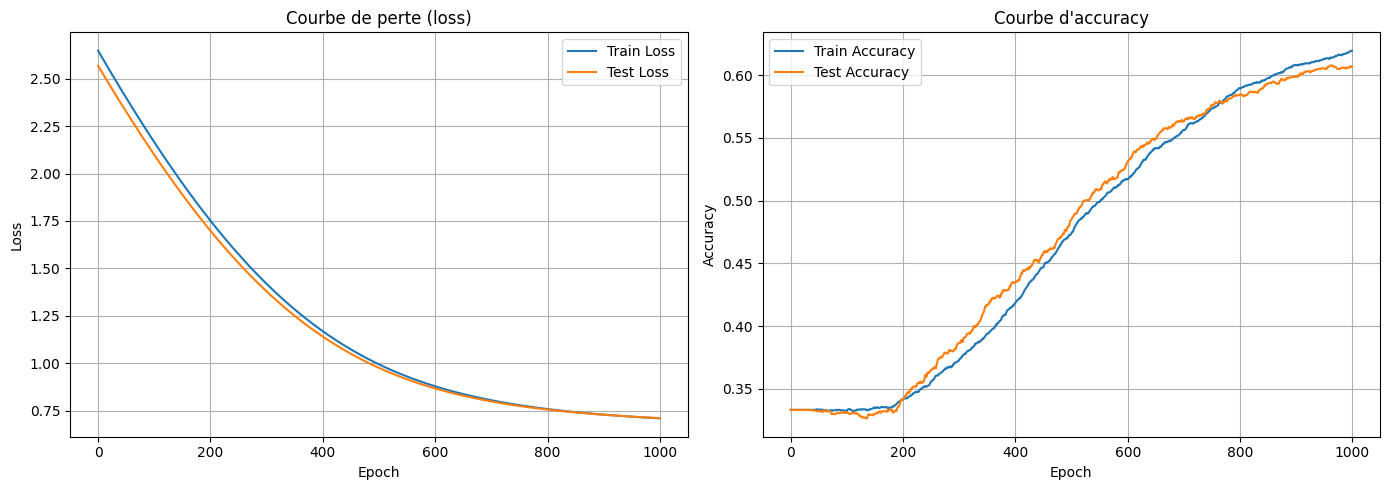

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Courbe de perte (Loss)
axs[0].plot(model.train_loss, label='Train Loss')
axs[0].plot(model.test_loss, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Courbe de perte (loss)')
axs[0].grid(True)
axs[0].legend()

# Courbe d'accuracy
axs[1].plot(model.train_accuracy, label='Train Accuracy')
axs[1].plot(model.test_accuracy, label='Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Courbe d\'accuracy')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()